# WRDS & SQL

**Author:** Ties de Kok ([Personal Website](https://www.tiesdekok.com))  <br>
**Last updated:** October 2022  
**Python version:** Python 3.6+     
**Recommended environment: `researchPython`**

In [1]:
import os
recommendedEnvironment = 'researchPython'
if os.environ['CONDA_DEFAULT_ENV'] != recommendedEnvironment:
    print('Warning: it does not appear you are using the {0} environment, did you run "conda activate {0}" before starting Jupyter?'.format(recommendedEnvironment))

<div style='border-style: solid; padding: 10px; border-color: black; border-width:5px;  text-align: left; margin-top:20px; margin-bottom: 20px;'>
<span style='color:black; font-size: 30px; font-weight:bold;'>Introduction</span>
</div>

<div style='border-style: solid; padding: 5px; border-color: darkred; border-width:5px;  text-align: center; margin-left: 100px; margin-right:100px;'>
<span style='color:black; font-size: 20px; font-weight:bold;'> Make sure to open up the respective tutorial notebook(s)! <br> That is what you are expected to use as primariy reference material. </span>
</div>

### Relevant tutorial notebooks:

1) [`0_python_basics.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)  


2) [`2_handling_data.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/2_handling_data.ipynb)  

## Import required packages

In [2]:
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np

from sqlite3 import connect

In [3]:
pd.options.display.float_format = '{:,.3f}'.format

<div style='border-style: solid; padding: 10px; border-color: black; border-width:5px;  text-align: center; margin-top:20px; margin-bottom: 20px;'>
<span style='color:black; font-size: 30px; font-weight:bold;'>SQL and Pandas</span>
</div>  

---------------
# Basic SQL query using Pandas
---------------

https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html

## Establish a connection

For the sake of demonstration we will rely on `sqlite`, which is a file-based database system that comes pre-installed with Python.

In [4]:
conn = connect(':memory:')

### Add some data to the dataset

In [5]:
dataset = pd.DataFrame(data = {
        'year' : np.random.choice([2018, 2019, 2020], 1000),
        'price' : np.random.randint(0,100_000, 1000),
        'city' : np.random.choice(['Seattle', 'Bellevue', 'Tacoma'], 1000),
    }
)

In [6]:
dataset.to_sql('demo_data', conn, if_exists='replace',  index=False)

1000

### Run some queries

Let's say we want to get all the rows where the city is Seattle.

## Query a Pandas DataFrame directly using SQL

There are several ways to query a dataframe directly, but the fastest one is through at tool called `duckDB`.

You need to install `duckDB` using `pip install duckDB`.

In [8]:
import duckdb

In [9]:
query = '''
SELECT *
FROM dataset
WHERE city = 'Seattle' AND price > 90000
'''.strip().replace('\n', ' ')

duckdb.query(query).df().sample(5)

,year,price,city
22,2019,90859,Seattle
8,2019,95875,Seattle
5,2019,91597,Seattle
3,2020,94555,Seattle
12,2019,95345,Seattle


<div style='border-style: solid; padding: 10px; border-color: black; border-width:5px;  text-align: center; margin-top:20px; margin-bottom: 20px;'>
<span style='color:black; font-size: 30px; font-weight:bold;'>WRDS</span>
</div>  

----
## 1a) Setup WRDS

You can interact with the WRDS PostgreSQL database in one of two ways:

1) Using the `wrds` Python package   
2) Directly using the `psycopg2` or `sqlalchemy` packages

We'll focus on the first method, but the 2nd method isn't much harder and has benefits sometimes.  

**Install the WRDS package:**

1. Activate your `researchPython` environment   
2. Install the package: `pip install wrds`   
3. Restart the kernel (optional probably)  
4. Import the package   


**Note:** The `WRDS` package really isn't much more than a few small convenience functions on top of `sqlalchemy`.    
With your newly acquired Python skills you should be able to understand the source code without much trouble:  
https://github.com/wharton/wrds/blob/master/wrds/sql.py

### Import library

In [10]:
import wrds

### Connect and authenticate

I recommend creating a .pgpass when prompted to avoid having to input your password every time.

The `.pgpass` file is stored in the following location:

***Windows:*** `"C:\Users\<USERNAME>\AppData\Roaming\postgresql\pgpass.conf"`   
***Unix:*** in your home directory as `.pgpass`

Pro-tip, if you change your password you can modify the pgpass file directly to save hassle. 

In [11]:
db = wrds.Connection(wrds_username = 'tcjkok')

Loading library list...
Done


-----
# Making a SQL query to WRDS is one line of code:

The difficulty comes from knowing:

1. What tables to use  
2. What columns to use  
3. What restrictions to apply  
4. How to make run somewhat performantly  

#### Example:

In [12]:
sql_query = """
SELECT 
    gvkey, cik, fdate, form, coname, fname
FROM 
    wrdssec_all.forms
WHERE 
    form = '10-K'
    AND fdate = '2018-03-15'::date
""".strip()

In [13]:
%%time
demo_df = db.raw_sql(sql_query)

CPU times: total: 0 ns
Wall time: 224 ms


In [14]:
demo_df.sample(5)

,gvkey,cik,fdate,form,coname,fname
151,None,0001648383,2018-03-15,10-K,"CNL Healthcare Properties II, Inc.",edgar/data/1648383/0001564590-18-005754.txt
84,None,0001326771,2018-03-15,10-K,Federal Home Loan Bank of Cincinnati,edgar/data/1326771/0001326771-18-000009.txt
105,185168,0001449794,2018-03-15,10-K,"Embassy Bancorp, Inc.",edgar/data/1449794/0001449794-18-000002.txt
7,012545,0000045919,2018-03-15,10-K,HARTE HANKS INC,edgar/data/45919/0000045919-18-000022.txt
55,106853,0001041550,2018-03-15,10-K,HOPFED BANCORP INC,edgar/data/1041550/0001193125-18-083696.txt


-----
# Figure out libraries, tables, and variables
----

## Using the WRDS package  

Useful commands:

- `db.list_libraries()`
- `db.list_tables(...)`
- `db.describe_table(library = ..., table = ...)`
- `db.get_table(library = ..., table = ..., obs = 5)`

### Show libraries

#### Show tables

For example for `audit_audit_comp`

#### Columns of a table and their datatype

For example, `audit_audit_comp` and `auditfees`

#### Show some sample data for the table

----
## Using a SQL Manager / Tool  

It can be helpful to inspect the tables manually outside of Python. You can do so using a SQL Manager / Tool / Inspector. 

There are many options. My personal favorite is `TablePlus`, however, that is paid software. A good free alternative is `DBeaver`:

https://dbeaver.io/download/

You can add the WRDS connection using these details:

- ***Database type:*** postgresql
- ***Host:*** wrds-pgdata.wharton.upenn.edu   
- ***Port:*** 9737  
- ***Database:*** wrds
- ***Username:*** your WRDS username   
- ***Password:*** you WRDS password

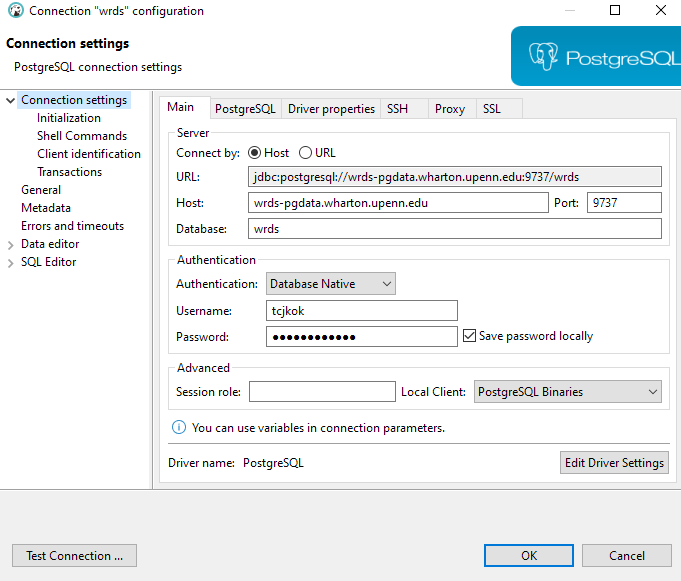

*When you connect for the first time it might ask to download driver files, which is alright, just let it download whatever it needs.*

## View the libraries

The SQL viewer will show a bunch of libraries that aren't returned by the ```.list_libraries()``` function.  

This is because the `WRDS` library does some filtering before it returns the list, you can see that in the source code:   

https://github.com/wharton/wrds/blob/76d187bd39ab817f5acfa208d4f2a2d9885210a5/wrds/sql.py#L159

Specifically, it check whether you have permission to access the library or not. `DBeaver` doesn't support that, so it just show everything. 

### View the tables

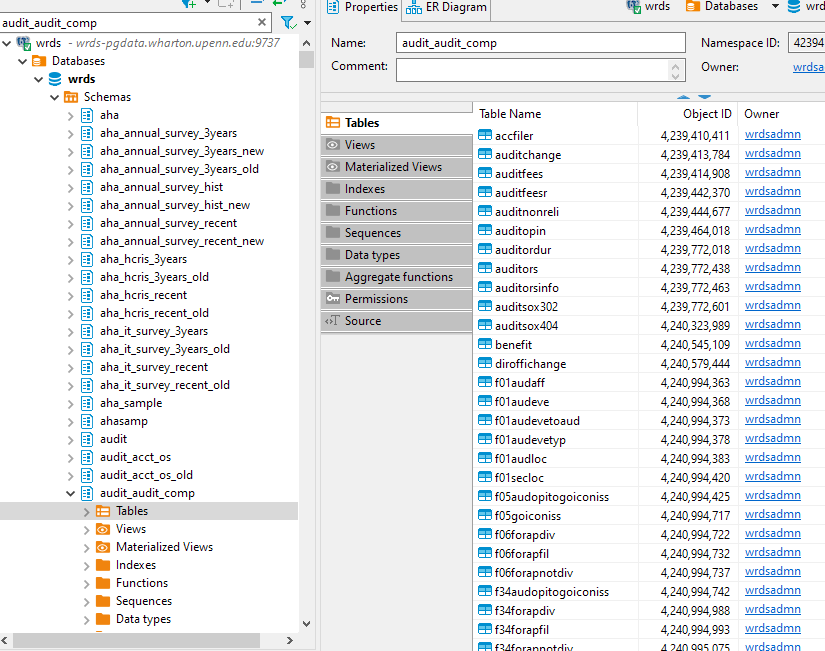

### View the columns and data

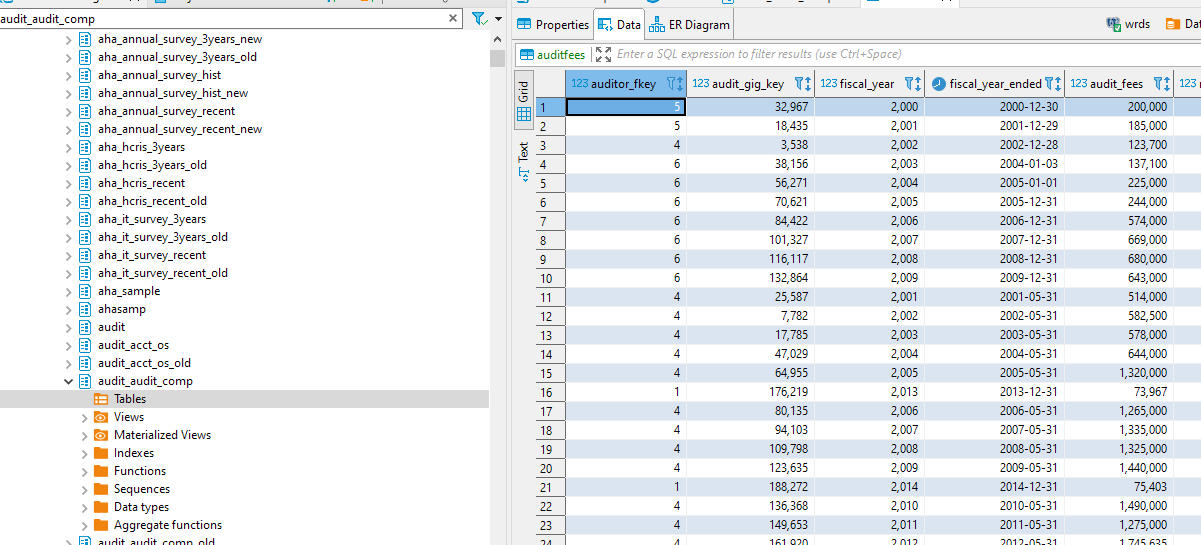

----
# How to figure out what all the column names mean?   
----

For example, let's say we see the column `closestqu_cshflst_fin_act_qtr` in `audit_audit_comp.auditfees`, what does it contain?

**Source #1:** data dictionaries

https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/   
https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/audit-analytics-and-oia-other-independent-audits/#products    
https://wrds-www.wharton.upenn.edu/data-dictionary/audit_audit_comp/auditfees/

This tells us that `closestqu_cshflst_fin_act_qtr` is `CLOSESTQU_CSHFLST_CASH_FROM_FINANCING_ACTIVITIES_QTR`

**Source #2:** WRDS variable search

https://wrds-www.wharton.upenn.edu/search/?activeTab=navVariablesSearchTab

This can help you narrow down where variables are mentioned, which can be useful.  

**Source #3:** Table manuals

These are usually best found by going to the corresponding query page on WRDS.com, and then clicking "manuals and overviews":

https://wrds-www.wharton.upenn.edu/pages/get-data/audit-analytics/audit-compliance/audit-fees/

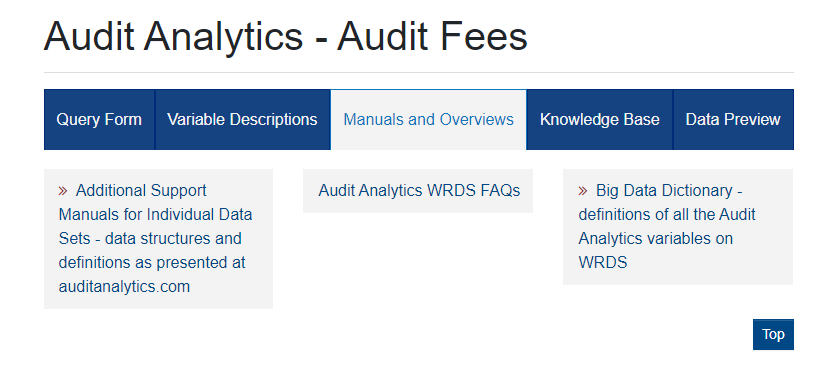

Using the primary key from source #1, we can find the actual description in the "Financial Block" tab of the "3_AUDIT_FEES.xlsx" file:

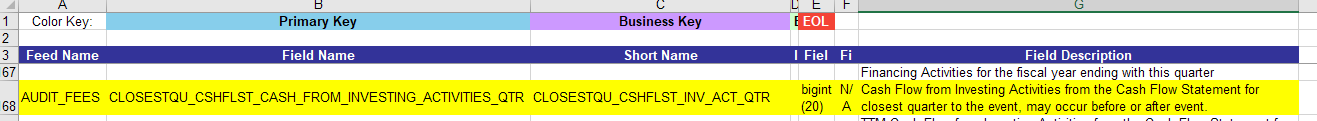

**Source #4:** email WRDS or the data vendor and ask

In [23]:
sample_df['closestqu_cshflst_fin_act_qtr']

0     -587,000.000
1   -1,165,000.000
2   -3,729,000.000
3       15,000.000
4   -1,100,000.000
Name: closestqu_cshflst_fin_act_qtr, dtype: float64

----
# How to query data
---

Let's say we want the auditfees data for Tesla.

Tesla has CIK: `0001318605` and the `auditfees` table uses CIK codes for the `company_fkey` column.

We could retrieve all the data using `get_table()` but that'd be (very) slow. 

Instead, we can create a SQL query and run it using `.raw_sql()`.

### Using `.raw_sql()`

### You can also run the same SQL query in `DBeaver` for debugging  

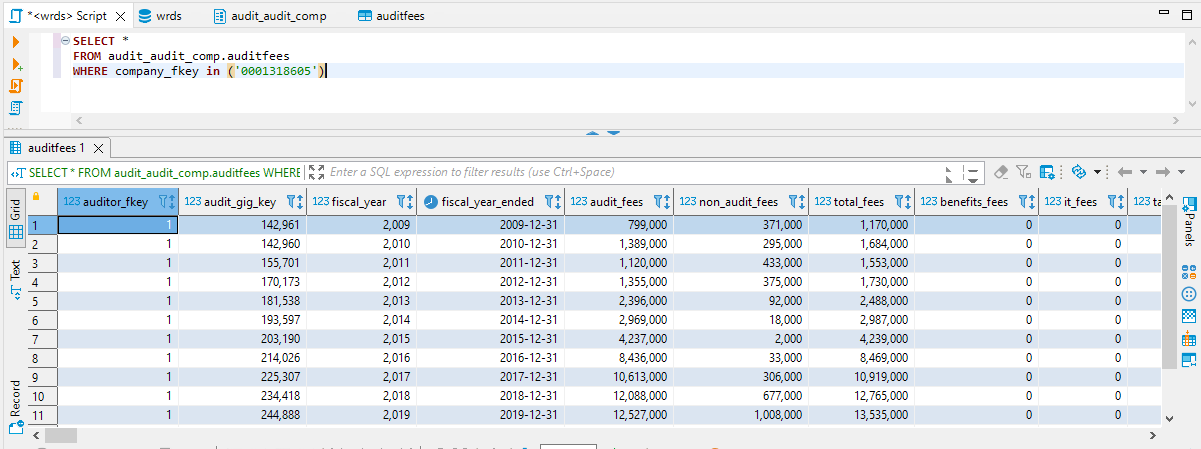

In [27]:
print(sql_query)

SELECT * 
FROM audit_audit_comp.auditfees
WHERE company_fkey in ('0001318605')


---
## Make it dynamic for any CIK

In [28]:
cik_list = [
    '0001318605', # Tesla
    '0000037996', # Ford
    '0001467858' # General Motors (GM)
]

column_names = [
    'best_edgar_ticker', 
    'fiscal_year',
    'audit_fees', 
    'non_audit_fees', 
    'auditor_name'
]

<div style='border-style: solid; padding: 5px; border-color: darkgreen; border-width:5px;  text-align: center; margin-left: 100px; margin-right:100px;'>
<span style='color:black; font-size: 20px; font-weight:bold;'> Good point for Task 1</span>
</div>

-----
## More advanced WRDS SQL queries

SQL queries also enable you to perform aggregations and joins to return datasets that are already closer to what you need. 

This can drastically speed things up relative to downloading the full dataset and doing the aggregation in Pandas.

## Aggregation

See, for example: https://www.postgresqltutorial.com/postgresql-aggregate-functions/

Let's say we want to return the average `total_fees` by `fiscal_year`.

You perform aggregations using `GROUP BY`:

## Join

We can join tables together using one of the join operations:

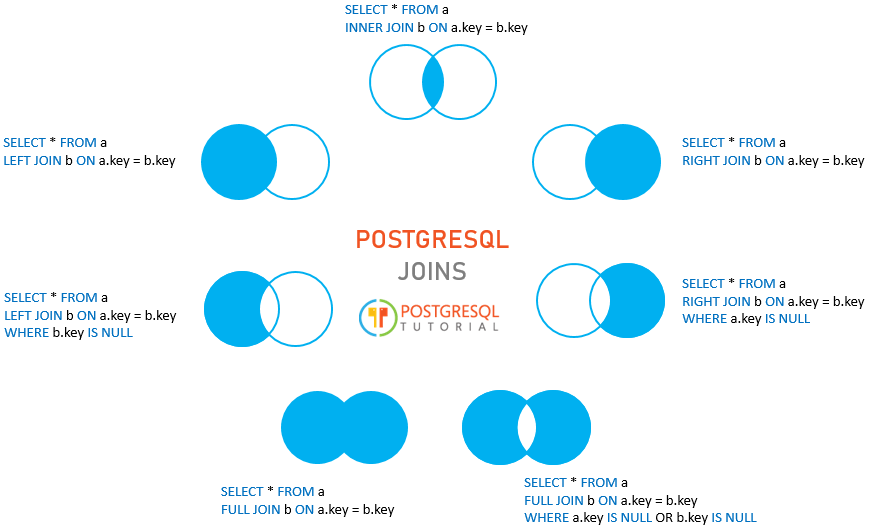  
*Source: https://www.postgresqltutorial.com/postgresql-tutorial/postgresql-joins/*

---
### Simple example

Let's say we want to add the IBES Ticker to the CSRP Permno.

https://wrds-www.wharton.upenn.edu/pages/get-data/linking-suite-wrds/

***Important note:*** The `score` column is very important here, which I am ignoring for the sake of demoing a join.

**Step 0:** Task

Let's say that we need to add the CSRP Permno to the following dataset:

In [36]:
query = """
SELECT 
    ticker, cusip, cname, analyst, itext, revdats
FROM 
    tr_ibes.recddet
WHERE
    ticker = 'AAPL'
    AND revdats > '2018-01-01'::date
""".strip()

db.raw_sql(query)

,ticker,cusip,cname,analyst,itext,revdats
0,AAPL,03783310,APPLE COMPUTER,ABRAMOWITZ W,STRONG BUY,2022-08-01
1,AAPL,03783310,APPLE INC,CROSS S,STRONG BUY,2022-03-08
2,AAPL,03783310,APPLE INC,SACCONAGHI T,STRONG BUY,2018-01-29
3,AAPL,03783310,APPLE INC,ABRAMSKY M,BUY,2019-01-27
4,AAPL,03783310,APPLE INC,MUNSTER G,BUY,2022-09-08
...,...,...,...,...,...,...
128,AAPL,03783310,APPLE,CROCKETT B,HOLD,2022-09-07
129,AAPL,03783310,APPLE,KOH E,BUY,2022-05-04
130,AAPL,03783310,APPLE,RESEARCH DEPA,UNDERPERFORM,2022-09-12
131,AAPL,03783310,APPLE,CROSS S,BUY,2022-09-06


**Step 1:** Figure out what library and table contains both the IBES Ticker and the CSRP Permno

https://wrds-www.wharton.upenn.edu/pages/get-data/linking-suite-wrds/ibes-crsp-link/

In [37]:
db.get_table(library = 'wrdsapps_link_crsp_ibes', table = 'ibcrsphist', obs= 5)

,ticker,permno,ncusip,sdate,edate,score
0,0000,"14,471.000",87482X10,2014-02-20,2016-08-31,1.000
1,0001,"14,392.000",26878510,2014-02-20,2019-05-22,1.000
2,0001,NaN,None,2019-06-20,None,6.000
3,0004,"14,418.000",02504D10,2014-02-20,2018-08-24,1.000
4,000R,"14,378.000",14163310,2014-02-20,2020-02-10,1.000


**Step 2:** Create SQL query that contains the join

---
### Advanced example

It is possible to combine aggregations and joins together using subqueries.

A subquery allows you to perform operations in sequency and you seperate/indicate them using `( ... )`

**Task:**

Let's say we want to add the number of 8K filings per year to the dataset of average audit fees. 

We can derive the number of 8K filings from the `wrdssec_all` > `items8k` dataset.

#### Let's first just get query that can calculate the number of 8k filings per year

In [39]:
sql_query = """
SELECT 
    DATE_PART('year', rdate) AS fiscal_year,
    COUNT (fname) AS number_of_8k_filings
FROM 
    wrdssec_all.items8k
WHERE 
    form = '8-K'
    AND rdate >= '2018-01-01'::date
GROUP BY
    fiscal_year
""".strip()

In [40]:
%%time
form_8k_df = db.raw_sql(sql_query)

CPU times: total: 0 ns
Wall time: 1.47 s


In [41]:
form_8k_df = form_8k_df[form_8k_df.fiscal_year < 2023]
form_8k_df

,fiscal_year,number_of_8k_filings
0,"2,018.000",145612
1,"2,019.000",139196
2,"2,020.000",156186
3,"2,021.000",179969
4,"2,022.000",140499


### Combine example

In [42]:
sql_query = """
SELECT * FROM (
    SELECT 
        fiscal_year::integer,
        AVG (audit_fees) AS avg_audit_fees,
        company_fkey AS cik
    FROM 
        audit_audit_comp.auditfees
    WHERE 
        fiscal_year > 2017
    GROUP BY
        fiscal_year, cik
) AS l 
INNER JOIN (
    SELECT 
        DATE_PART('year', rdate)::integer AS fiscal_year,
        COUNT (fname) AS number_of_8k_filings,
        cik
    FROM 
        wrdssec_all.items8k
    WHERE
        form = '8-K'
        AND rdate >= '2018-01-01'::date
    GROUP BY
        fiscal_year, cik
) as r USING (cik, fiscal_year)
""".strip()

In [43]:
%%time
combo_example_df = db.raw_sql(sql_query)

CPU times: total: 93.8 ms
Wall time: 1.15 s


In [44]:
combo_example_df

,cik,fiscal_year,avg_audit_fees,number_of_8k_filings
0,0001104506,2021,"1,906,000.000",24
1,0001018164,2020,"1,490,540.000",20
2,0001635650,2018,"475,000.000",34
3,0001674168,2019,"3,664,236.000",21
4,0001527590,2018,"1,730,000.000",22
...,...,...,...,...
23897,0001841610,2021,"165,000.000",13
23898,0001623526,2019,"991,000.000",6
23899,0001836274,2021,"128,660.000",19
23900,0001489588,2019,"30,900.000",5


<div style='border-style: solid; padding: 5px; border-color: darkgreen; border-width:5px;  text-align: center; margin-left: 100px; margin-right:100px;'>
<span style='color:black; font-size: 20px; font-weight:bold;'> Good point for Task 2</span>
</div>

----
# How to convert SAS code to Python


Let's say someone gives you this SAS code:

```sas
**Get delisting oberservations**;
rsubmit;
    proc sql;
        create table rvtemp as
        select * from crsp.dse
        where dlstcd > 199 and 1960 le year(DATE) le 2020
        order by dlstcd;
endrsubmit;
```

You could run it in SAS, and that might be the best move, however, you converting it to Python SQL wouldn't be too hard. 

There are two primary things to watch out for:  

1. The SQL flavor used by SAS is non-standard and not `PostgreSQL`. So things like `le` and `year()` aren't supported and should be `>=` and `DATE_PART()`   
2. In most cases the library, table, and variable names are the same. However, I have noticed a few edge cases where they can differ.

In [45]:
sql_query = """
SELECT * FROM crsp.dse
where dlstcd > 199 and 1960 le year(DATE) le 2020
ORDER BY DLSTCD
""".strip()

In [46]:
try:
    tmp_df = db.raw_sql(sql_query)
except Exception as e:
    print(str(e)[:300])

(psycopg2.errors.SyntaxError) syntax error at or near "le"
LINE 2: where dlstcd > 199 and 1960 le year(DATE) le 2020
                                    ^

[SQL: SELECT * FROM crsp.dse
where dlstcd > 199 and 1960 le year(DATE) le 2020
ORDER BY DLSTCD]
(Background on this error at: https://sqlalche.m


**Fixed version:**

## SAS Data step

In SAS you can also make WRDS queries using SAS data steps as an alternative to SQL queries. 

Converting this is similarly straightforward, although you'll have to first reverse-engineer the logic:

```sas
**Obtain variables from Compustat. Compustat provides financial variables;

rsubmit;
    data compustat (keep= DATADATE GVKEY Cal_year cik FYEARQ EPSPXQ FQTR RDQ PRCCQ CSHOQ CSHOPQ EXCHG CAPXY PPENTQ ATQ CEQQ IBQ NIQ DPQ OANCFY 
    XRDQ FCAQ FCAY SALEQ FIC CURCDQ AQCY DATACQTR DATAFQTR CEQQ TXDBQ DLCQ DLTTQ PRCCQ EPSPIQ EPSFIQ APDEDATEQ EPSFIQ EPSFXQ CONM
    GDWLIPQ WDPQ SPIQ AQPQ GLPQ GDWLIPQ SETPQ RCPQ WDPQ DTEPQ RDIPQ SPIOPQ XOPRQ ATQ SALEQ RECCHY INVCHY APALCHY TXACHY AOLOCHY NIQ CEQQ FYR DATAFQTR);
        set compd.fundq;
        where (indfmt='INDL') and (datafmt='STD') and (popsrc='D') and (consol='C') and (CURCDQ='USD');
        if  FIC = 'USA';
        if year(datadate)>2010;
        Cal_year=year(datadate);
    run;
endrsubmit;
```

The on tricky thing here is that the `compd` library doesn't exist in the PostgreSQL equivalent. In the PostgreSQL equivalent it is called `comp_na_daily_all`.

In [50]:
tmp = """DATADATE GVKEY cik FYEARQ EPSPXQ FQTR RDQ PRCCQ CSHOQ CSHOPQ EXCHG CAPXY PPENTQ ATQ CEQQ IBQ NIQ DPQ OANCFY 
    XRDQ FCAQ FCAY SALEQ FIC CURCDQ AQCY DATACQTR DATAFQTR CEQQ TXDBQ DLCQ DLTTQ PRCCQ EPSPIQ EPSFIQ APDEDATEQ EPSFIQ EPSFXQ CONM
    GDWLIPQ WDPQ SPIQ AQPQ GLPQ GDWLIPQ SETPQ RCPQ WDPQ DTEPQ RDIPQ SPIOPQ XOPRQ ATQ SALEQ RECCHY INVCHY APALCHY TXACHY AOLOCHY NIQ CEQQ FYR DATAFQTR
"""
columns = tmp.split()
columns[:4]

['DATADATE', 'GVKEY', 'cik', 'FYEARQ']

----
# Tasks

## Task 1

**Objective:** Get all events from the RavenPack - Equities - Dow Jones dataset that meet the following criteria:

- The `type` is "earnings"
- The country is NL
- The year is 2019 (*hint:* check the tables)



https://wrds-www.wharton.upenn.edu/pages/get-data/ravenpack-news-analytics-40/equities/dow-jones-edition/

## Task 2 

Following up on ***task 1***, use the same Ravenpack dataset to show the number of news event by country and by sub_type

You can impose the following limits to make it faster / easier to look at:

- Only 2019  
- You can limit it to just these `sub_type` values: positive, negative, up, down  
- You can limit the countries to: DE, FR, NL, BE

Output example:

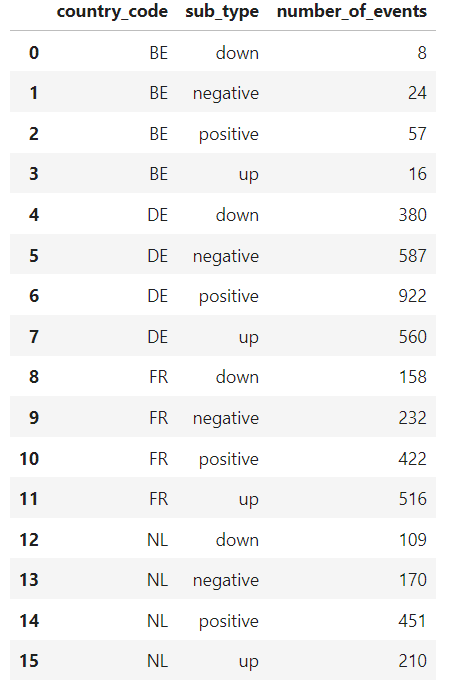